#Multilabel label classification with transfer learning

In [1]:
!nvidia-smi

Sun Jan 30 15:00:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#Downloading the zip file 10 class of food but this time only 10 percentage of training data
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-01-30 15:00:43--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.194.128, 142.250.152.128, 64.233.191.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   109MB/s    in 1.5s    

2022-01-30 15:00:45 (109 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
#Lets walk into the dataset
import os 

for dirnames, filenames, dirpath in os.walk("10_food_classes_10_percent"):
  print(f'There are {len(dirpath)} directory with {len(filenames)} images in the {dirnames}')

There are 0 directory with 2 images in the 10_food_classes_10_percent
There are 0 directory with 10 images in the 10_food_classes_10_percent/train
There are 75 directory with 0 images in the 10_food_classes_10_percent/train/hamburger
There are 75 directory with 0 images in the 10_food_classes_10_percent/train/fried_rice
There are 75 directory with 0 images in the 10_food_classes_10_percent/train/sushi
There are 75 directory with 0 images in the 10_food_classes_10_percent/train/pizza
There are 75 directory with 0 images in the 10_food_classes_10_percent/train/chicken_curry
There are 75 directory with 0 images in the 10_food_classes_10_percent/train/ice_cream
There are 75 directory with 0 images in the 10_food_classes_10_percent/train/ramen
There are 75 directory with 0 images in the 10_food_classes_10_percent/train/grilled_salmon
There are 75 directory with 0 images in the 10_food_classes_10_percent/train/steak
There are 75 directory with 0 images in the 10_food_classes_10_percent/train

There are 75 image in training data of each label.

In [4]:
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [5]:
#let find the class names
import pathlib
import numpy as np

data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))

print(f'There are {len(class_names)} classes a given data sets')
print(class_names)

There are 10 classes a given data sets
['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [6]:
##Data preparation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#For future reference we are repeating the code
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

#Data Scaling or Normalization
train_datgen = ImageDataGenerator(rescale=1/225.)
test_datagen = ImageDataGenerator(rescale=1/225.)

#Training and testing data sets:
print("Training_data:")
train_data = train_datgen.flow_from_directory(directory = train_dir,
                                              target_size=(224,224),
                                              batch_size=32,
                                              class_mode="categorical")
print("Testing Data:")
test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size =(224,224),
                                             batch_size=32,
                                             class_mode="categorical")



Training_data:
Found 750 images belonging to 10 classes.
Testing Data:
Found 2500 images belonging to 10 classes.


We got 750 image in training dataset with each class of 75 images.

In [25]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

##Creating a model with tensorboard hub

In [9]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [10]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficentnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [15]:
#Create a model
def create_model(model_url, num_classes=10):

  #Download the model_url
  feature_extraction_layer = hub.KerasLayer(model_url,
                                            trainable=False,
                                            name = 'feature_extraction_layer',
                                            input_shape = (224,224,3))
  
  #Create our own model
  model = tf.keras.Sequential([
    feature_extraction_layer,
    layers.Dense(num_classes, activation='softmax', name="output_layer")
  ])

  return model


In [16]:
resnet_model = create_model(resnet_url, num_classes=10)

resnet_model.compile(loss="categorical_crossentropy",
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ["accuracy"])

In [27]:
# Fit the model
resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220130-154829
Epoch 1/5
24/24 [==============================] - 38s 1s/step - loss: 1.9607 - accuracy: 0.3347 - val_loss: 1.2229 - val_accuracy: 0.6200
Epoch 2/5
24/24 [==============================] - 21s 916ms/step - loss: 0.8929 - accuracy: 0.7307 - val_loss: 0.8823 - val_accuracy: 0.7064
Epoch 3/5
24/24 [==============================] - 21s 908ms/step - loss: 0.6076 - accuracy: 0.8253 - val_loss: 0.7703 - val_accuracy: 0.7516
Epoch 4/5
24/24 [==============================] - 23s 999ms/step - loss: 0.4666 - accuracy: 0.8867 - val_loss: 0.7109 - val_accuracy: 0.7684
Epoch 5/5
24/24 [==============================] - 24s 1s/step - loss: 0.3737 - accuracy: 0.9293 - val_loss: 0.6737 - val_accuracy: 0.7800


In [37]:
#plotting the curve
import matplotlib.pyplot as plt
%matplotlib inline


def plot_curve(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))
  
  plt.plot(epochs, loss, label ="Training_loss")
  plt.plot(epochs, val_loss, label = "Valisation_loss")
  plt.title("Loss_curve")
  plt.legend()
  plt.xlabel(epochs)

  plt.figure()
  plt.plot(epochs, accuracy , label ="accuracy")
  plt.plot(epochs, val_accuracy, label = "Validation_accuracy")
  plt.title("Accuracy_curve")
  plt.legend()
  plt.xlabel(epochs);

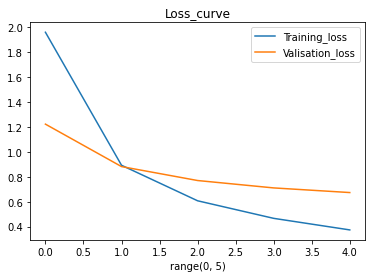

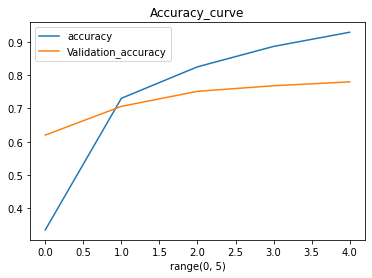

In [38]:
plot_curve(resnet_history)

In [39]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [40]:
resnet_model.evaluate(test_data)

79/79 [==============================] - 18s 224ms/step - loss: 0.6737 - accuracy: 0.7800


[0.6736946105957031, 0.7799999713897705]

In [42]:
train_data.num_classes

10

In [45]:
#Model_creation
efficient_model = create_model(model_url = efficentnet_url, num_classes = train_data.num_classes)

#Model_compilation
efficient_model.compile(loss="categorical_crossentropy",
                        optimizer = tf.keras.optimizers.Adam(),
                        metrics = ["accuracy"])

#Fitting the model
efficient_history = efficient_model.fit(train_data,
                                        epochs=5,
                                        steps_per_epoch=len(train_data),
                                        validation_data=test_data,
                                        validation_steps=len(test_data),
                                        callbacks = [create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                experiment_name = "efficient_name")])

Saving TensorBoard log files to: tensorflow_hub/efficient_name/20220130-162721
Epoch 1/5
24/24 [==============================] - 43s 1s/step - loss: 1.8237 - accuracy: 0.4400 - val_loss: 1.2578 - val_accuracy: 0.7532
Epoch 2/5
24/24 [==============================] - 20s 840ms/step - loss: 1.0535 - accuracy: 0.7800 - val_loss: 0.8608 - val_accuracy: 0.8236
Epoch 3/5
24/24 [==============================] - 18s 792ms/step - loss: 0.7681 - accuracy: 0.8293 - val_loss: 0.6997 - val_accuracy: 0.8460
Epoch 4/5
24/24 [==============================] - 19s 836ms/step - loss: 0.6212 - accuracy: 0.8627 - val_loss: 0.6190 - val_accuracy: 0.8560
Epoch 5/5
24/24 [==============================] - 19s 807ms/step - loss: 0.5250 - accuracy: 0.8920 - val_loss: 0.5671 - val_accuracy: 0.8620


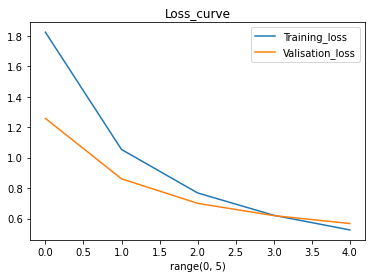

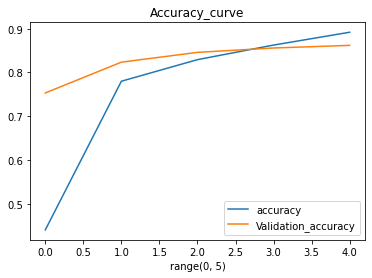

In [46]:
plot_curve(efficient_history)

In [47]:
efficient_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [48]:
efficient_model.evaluate(test_data)

79/79 [==============================] - 15s 187ms/step - loss: 0.5671 - accuracy: 0.8620


[0.5671034455299377, 0.8619999885559082]

In [49]:
#Tensorboard dev record
!tensorboard dev upload --logdir ./tensorflow_hub/ \
 --name "Efficient vs Resnet" \
 --description "Comparing two models with 10 percent data from the original data sets" \
 --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=fpGBkKM0jRDGibJggOngUfsOJLO8LN&prompt=consent&access_type=off

In [52]:
!tensorboard dev list

https://tensorboard.dev/experiment/x0Wy0abPT0KYi4aRXMSL8Q/
	Name                 Efficient vs Resnet
	Description          Comparing two models with 10 percent data from the original data sets
	Id                   x0Wy0abPT0KYi4aRXMSL8Q
	Created              2022-01-30 16:36:33 (5 minutes ago)
	Updated              2022-01-30 16:36:35 (5 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5922391
Total: 1 experiment(s)


In [54]:
!tensorboard dev delete --experiment_id x0Wy0abPT0KYi4aRXMSL8Q

Deleted experiment x0Wy0abPT0KYi4aRXMSL8Q.


In [56]:
!tensorboard dev list

No experiments. Use `tensorboard dev upload` to get started.


From this we will know the power of transfer learning with less data we will acheive the maximum accuracy..And we use various trained model for time saving.